# Feature Selection

Python notebook re: feature elimination decisions, logs results in a table

Main output(s):
- feature_selection.csv: feature importance log, a tabular record of the ranking of all features by importance score (as per [02_EDA_feature_selection_and_engineering](https://docs.google.com/document/d/1Kl0Oz5YV63c0b6lbUHhTlcTJ7h4KpRAAGrQZfKX6Zyw/edit?usp=sharing))
- features_for_personalization: smaller, optimized feature set containing only the top features plus metadata

Authors: Brian R. Mullen, Sero Toriano Parel, Revati Jadhav, Carrie Clark, Philip Nelson

Date: 2025-10-21

## Imports

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Load the cleaned data from EDA
cleaned_data_path = "../../emg_data/features_emg_data_cleaned.csv"
df_no_outliers = pd.read_csv(cleaned_data_path)
print(f"Loaded cleaned data: {df_no_outliers.shape}")

# Define feature columns (same logic as before)
metadata_cols = ['user', 'gesture', 'stage', 'is_outlier']
all_columns = df_no_outliers.columns.tolist()
feature_cols = [col for col in all_columns if col not in metadata_cols]
print(f"Feature columns: {len(feature_cols)}")

Loaded cleaned data: (125439, 164)
Feature columns: 160


## Random forest for feature importance

In [2]:
# Use Random Forest to find important features
# NOTE: This is a rate-limiting step; may take some time to run

# Prepare data for machine learning
X = df_no_outliers[feature_cols].copy()
y = df_no_outliers['gesture']

print(f"X shape: {X.shape}, y shape: {y.shape}")

# Train a simple Random Forest
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=20)
rf_model.fit(X, y)

# Get feature importance scores
importance_scores = rf_model.feature_importances_

# Create a dataframe to see results clearly
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance_scores
}).sort_values('importance', ascending=False)

print("Top 20 most important features:")
print(feature_importance_df.head(20))

X shape: (125439, 160), y shape: (125439,)
Top 20 most important features:
                 feature  importance
68     ch04_fft-maxpower    0.014873
148  ch04_thresh2-events    0.014274
21           ch05_maxabs    0.014001
5               ch05_rms    0.013798
4               ch04_rms    0.013712
20           ch04_maxabs    0.013428
37              ch05_mav    0.012735
69     ch05_fft-maxpower    0.012031
36              ch04_mav    0.012007
3               ch03_rms    0.011731
74     ch10_fft-maxpower    0.011348
19           ch03_maxabs    0.011299
38              ch06_mav    0.011109
10              ch10_rms    0.011012
6               ch06_rms    0.010589
35              ch03_mav    0.010529
149  ch05_thresh2-events    0.010499
42              ch10_mav    0.010434
29           ch13_maxabs    0.010393
39              ch07_mav    0.009794


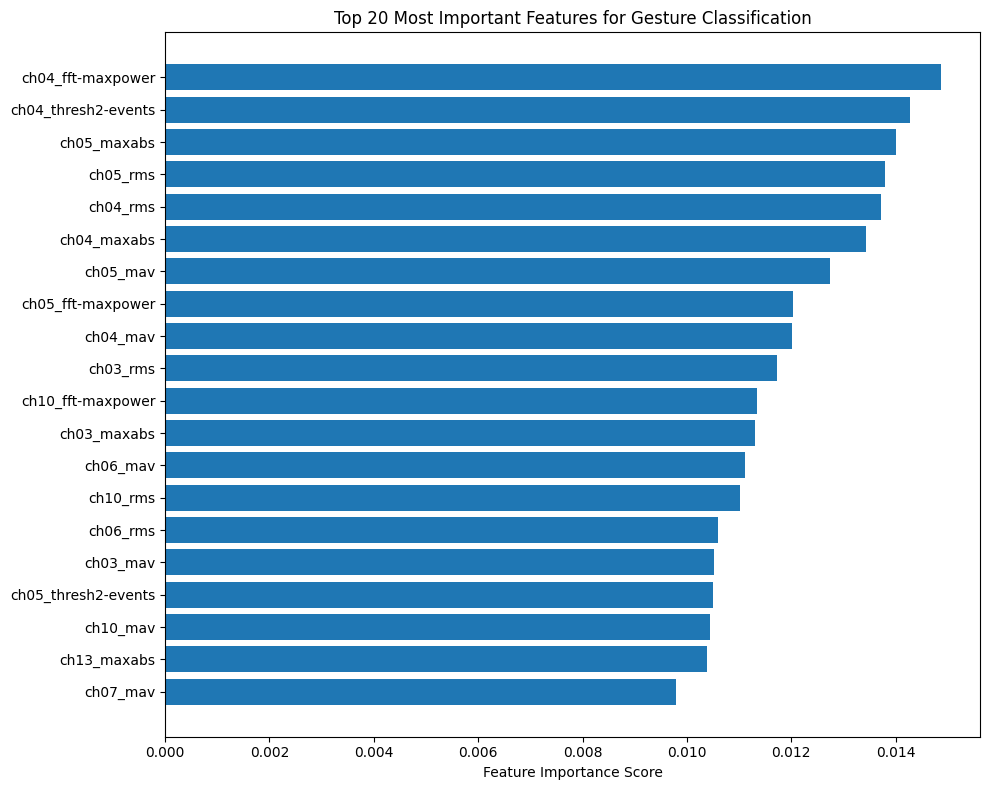

In [3]:
# Plot top 20 features
top_20 = feature_importance_df.head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Most Important Features for Gesture Classification')
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()
plt.show()

## Correlation analysis of top features

In [4]:
# Check for highly correlated features among top features

# Look at top 50 features
top_50_features = feature_importance_df.head(50)['feature'].tolist()

# Calculate correlations between top features
correlation_matrix = df_no_outliers[top_50_features].corr()

# Find features that are very similar (correlation > 0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = abs(correlation_matrix.iloc[i, j])
        if corr_value > 0.8:
            feat1 = correlation_matrix.columns[i]
            feat2 = correlation_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_value))

print(f"Found: {len(high_corr_pairs)} highly correlated feature pairs (r > 0.8)")

if high_corr_pairs:
    print("Some highly correlated features:")
    for feat1, feat2, corr in high_corr_pairs[:5]:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")

Found: 99 highly correlated feature pairs (r > 0.8)
Some highly correlated features:
  ch04_fft-maxpower <-> ch04_rms: 0.912
  ch04_fft-maxpower <-> ch04_maxabs: 0.851
  ch04_fft-maxpower <-> ch04_mav: 0.918
  ch04_thresh2-events <-> ch04_thresh3-events: 0.860
  ch05_maxabs <-> ch05_rms: 0.961


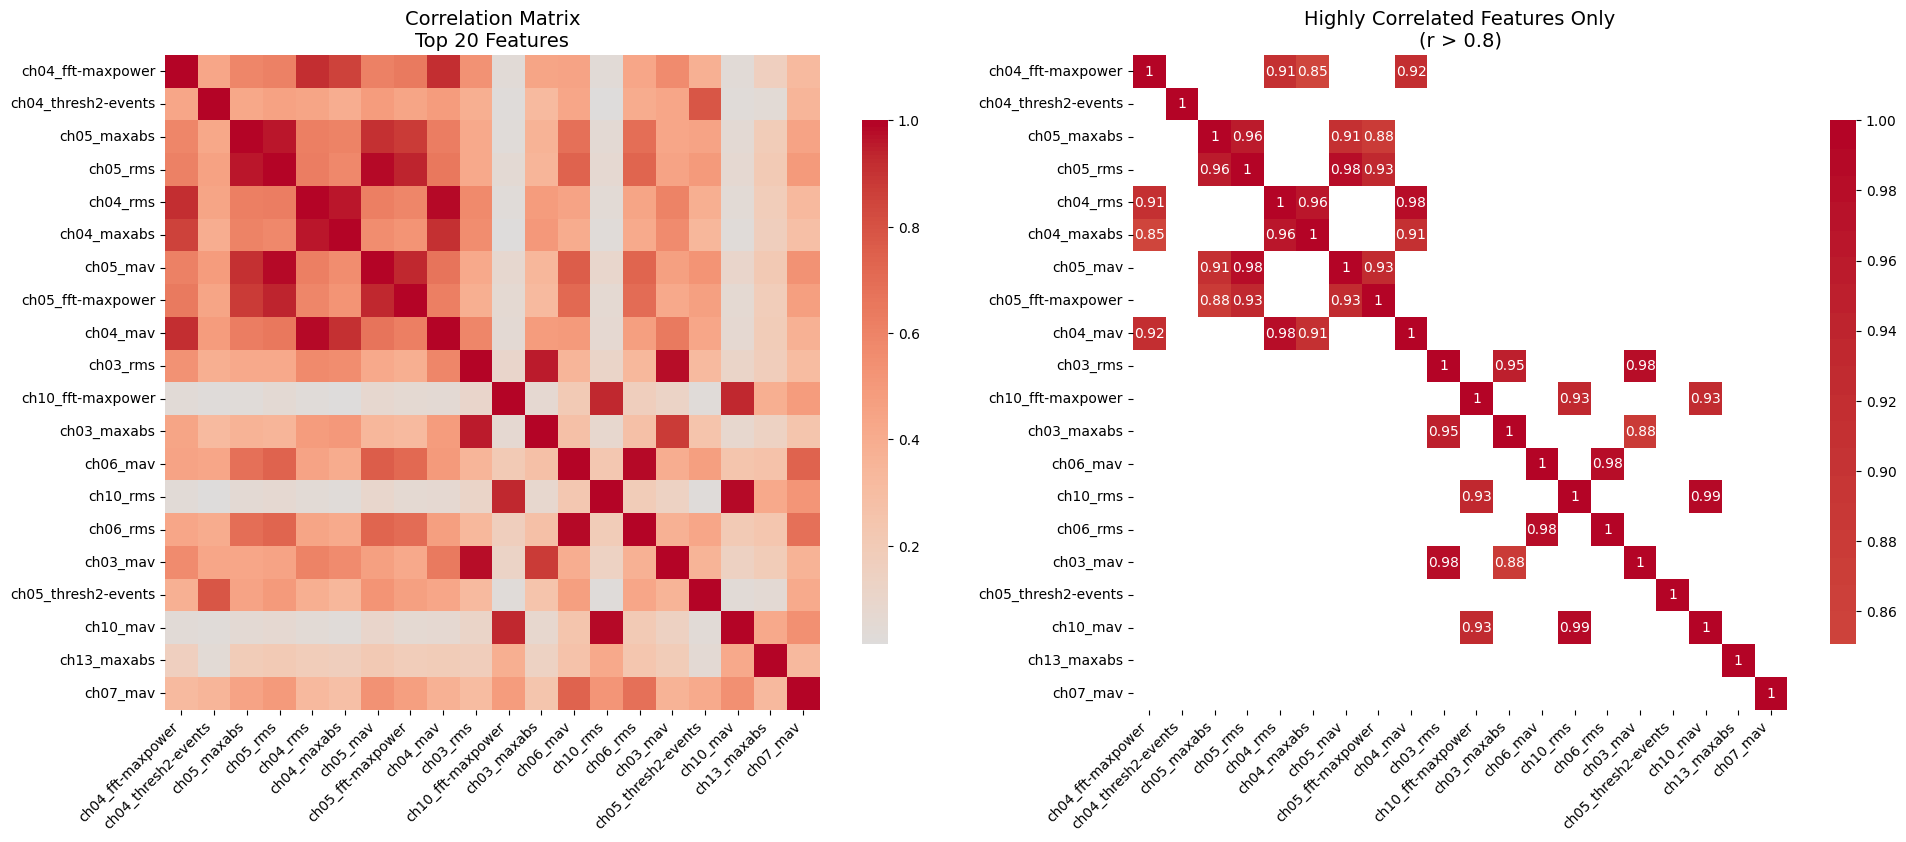

In [5]:
# Visualize correlation matrix of top features - SIDE BY SIDE

# Use top 20 features for the correlation matrix (easier to read)
top_20_for_corr = feature_importance_df.head(20)['feature'].tolist()

# Calculate correlation matrix for top 20 features
corr_matrix_top20 = df_no_outliers[top_20_for_corr].corr()

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: Full correlation matrix
sns.heatmap(corr_matrix_top20, 
            cmap='coolwarm', 
            center=0,
            annot=False,  # No numbers for cleaner look
            square=True,
            cbar_kws={'shrink': 0.8},
            ax=ax1)
ax1.set_title('Correlation Matrix\nTop 20 Features', fontsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Right plot: Only highly correlated pairs
high_corr_matrix = corr_matrix_top20.where(np.abs(corr_matrix_top20) > 0.8)

sns.heatmap(high_corr_matrix, 
            cmap='coolwarm', 
            center=0,
            annot=True,  # Show numbers for high correlations
            square=True,
            cbar_kws={'shrink': 0.8},
            mask=high_corr_matrix.isnull(),  # Hide non-correlated cells
            ax=ax2)
ax2.set_title('Highly Correlated Features Only\n(r > 0.8)', fontsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [6]:
# Print some statistics
print(f"Correlation Statistics for Top 20 Features:")
print(f"Total feature pairs: {len(corr_matrix_top20.columns) * (len(corr_matrix_top20.columns) - 1) // 2}")
print(f"Highly correlated pairs (r > 0.8): {len(high_corr_pairs)}")
print(f"Very highly correlated pairs (r > 0.9): {len([pair for pair in high_corr_pairs if pair[2] > 0.9])}")

Correlation Statistics for Top 20 Features:
Total feature pairs: 190
Highly correlated pairs (r > 0.8): 99
Very highly correlated pairs (r > 0.9): 53


## Remove redundant features

In [7]:
# Create final feature set by removing duplicates

# Start with top features
top_features = feature_importance_df.head(50)['feature'].tolist()
final_features = []

# Keep only one from each highly correlated pair
for feature in top_features:
    keep_feature = True
    
    # Check if this feature is very similar to any we already kept
    for kept_feature in final_features:
        if feature in correlation_matrix.columns and kept_feature in correlation_matrix.columns:
            corr_value = abs(correlation_matrix.loc[feature, kept_feature])
            if corr_value > 0.8:
                # They're very similar - check which is more important
                imp_current = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].values[0]
                imp_kept = feature_importance_df[feature_importance_df['feature'] == kept_feature]['importance'].values[0]
                
                if imp_current > imp_kept:
                    # Current feature is better, replace the old one
                    final_features.remove(kept_feature)
                    final_features.append(feature)
                    print(f"  Replaced {kept_feature} with {feature} (better importance)")
                keep_feature = False
                break
    
    if keep_feature and feature not in final_features:
        final_features.append(feature)

print(f"{len(final_features)} features after removing duplicates")

# Show what types of features we kept
print("Types of features in final set:")
feature_types = {}
for feature in final_features:
    if 'rms' in feature.lower():
        feature_types['RMS'] = feature_types.get('RMS', 0) + 1
    elif 'fft' in feature.lower():
        feature_types['FFT'] = feature_types.get('FFT', 0) + 1  
    elif 'max' in feature.lower():
        feature_types['Max'] = feature_types.get('Max', 0) + 1
    else:
        feature_types['Other'] = feature_types.get('Other', 0) + 1

for ftype, count in feature_types.items():
    print(f"  {ftype}: {count} features")

15 features after removing duplicates
Types of features in final set:
  FFT: 4 features
  Other: 5 features
  Max: 5 features
  RMS: 1 features


## Visualization of final feature set

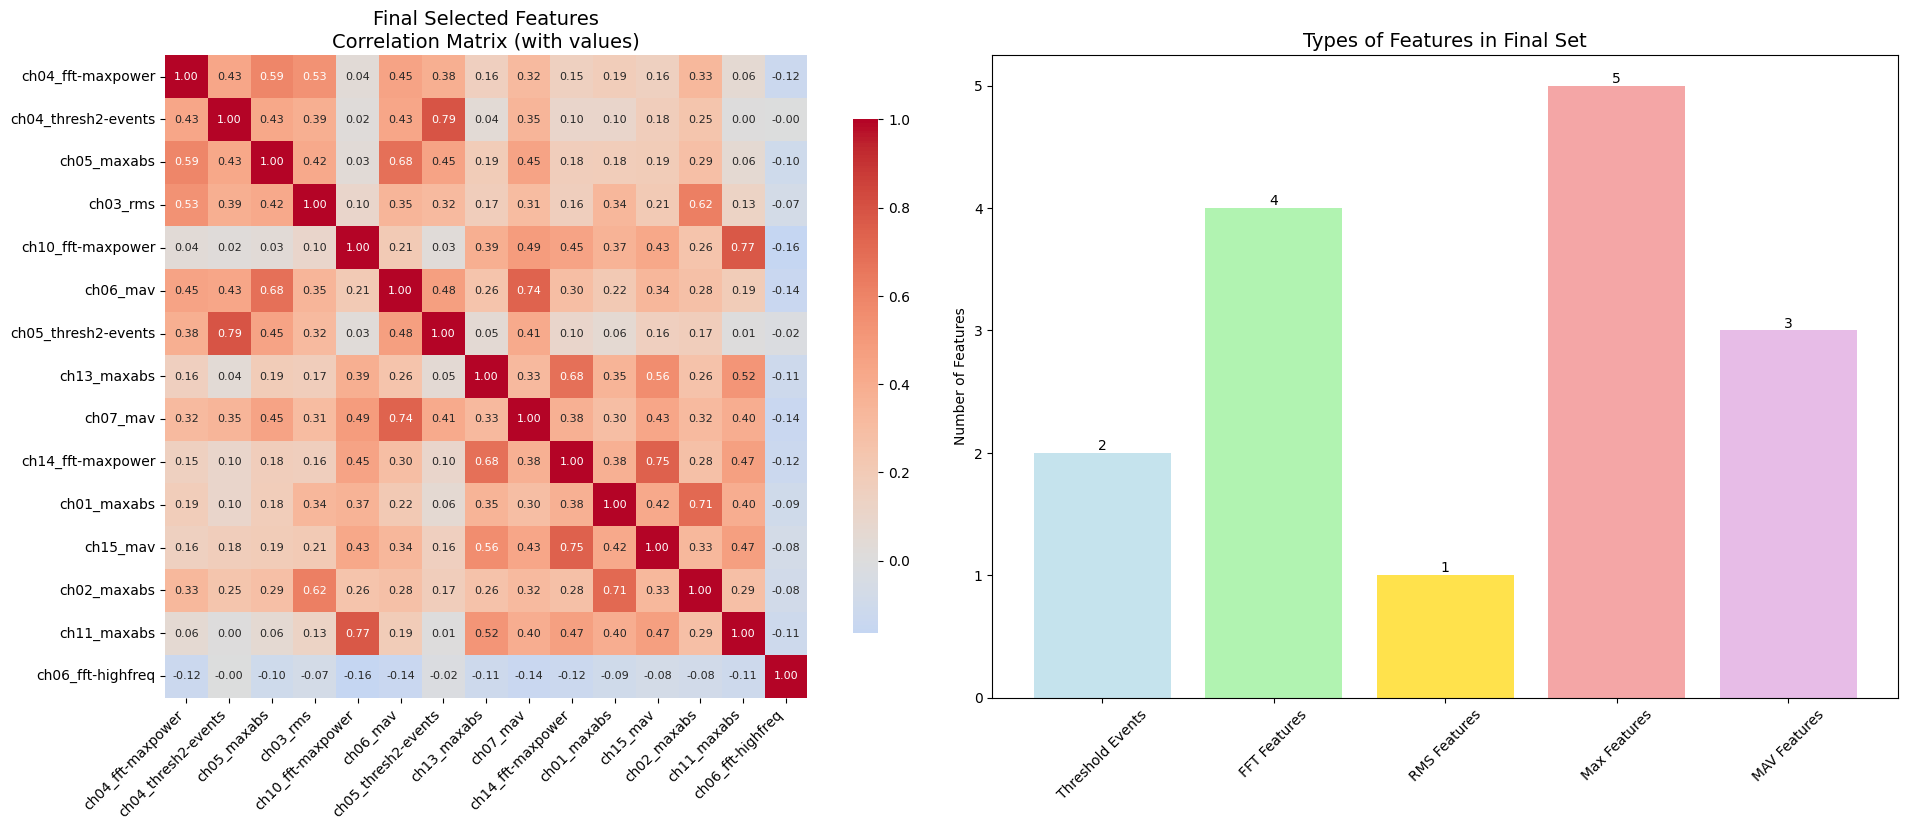

In [8]:
# Simple visualization of final feature selection results

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Correlation matrix of final selected features WITH NUMBERS

# Calculate correlation for our final features
final_corr_matrix = df_no_outliers[final_features].corr()

# Create the heatmap with correlation values
sns.heatmap(final_corr_matrix, 
            cmap='coolwarm', 
            center=0,
            annot=True,  # CHANGED: Now shows the correlation numbers
            square=True,
            cbar_kws={'shrink': 0.8},
            ax=ax1,
            fmt='.2f',  # Show 2 decimal places for the numbers
            annot_kws={'size': 8})  # Make the numbers a bit smaller

ax1.set_title('Final Selected Features\nCorrelation Matrix (with values)', fontsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Plot 2: Feature types breakdown with actual names

# Count feature types with better names
feature_type_counts = {
    'Threshold Events': 0,
    'FFT Features': 0, 
    'RMS Features': 0,
    'Max Features': 0,
    'MAV Features': 0
}

for feature in final_features:
    if 'thresh' in feature.lower():
        feature_type_counts['Threshold Events'] += 1
    elif 'fft' in feature.lower():
        feature_type_counts['FFT Features'] += 1
    elif 'rms' in feature.lower():
        feature_type_counts['RMS Features'] += 1
    elif 'max' in feature.lower():
        feature_type_counts['Max Features'] += 1
    elif 'mav' in feature.lower():
        feature_type_counts['MAV Features'] += 1

# Remove types with zero count
feature_type_counts = {k: v for k, v in feature_type_counts.items() if v > 0}

# Create bar chart
types = list(feature_type_counts.keys())
counts = list(feature_type_counts.values())
colors = ['lightblue', 'lightgreen', 'gold', 'lightcoral', 'plum']

bars = ax2.bar(types, counts, color=colors[:len(types)], alpha=0.7)
ax2.set_title('Types of Features in Final Set', fontsize=14)
ax2.set_ylabel('Number of Features')
ax2.tick_params(axis='x', rotation=45)

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [9]:
# Simple summary
print(f"Final Feature Selection:")
print(f"- Started with: 160 total features")
print(f"- Selected: {len(final_features)} features")
print(f"- Feature types selected:")
for feature_type, count in feature_type_counts.items():
    print(f"  - {feature_type}: {count}")

Final Feature Selection:
- Started with: 160 total features
- Selected: 15 features
- Feature types selected:
  - Threshold Events: 2
  - FFT Features: 4
  - RMS Features: 1
  - Max Features: 5
  - MAV Features: 3


## Save final dataset and feature importance

In [10]:
# Create final dataset with selected features

# Keep only metadata and our selected features
columns_to_keep = ['user', 'gesture'] + final_features
final_df = df_no_outliers[columns_to_keep].copy()

print(f"Final dataset shape: {final_df.shape}")
print(f"Columns in final dataset: {list(final_df.columns)}")

# Save to file
output_file = "../../emg_data/features_for_personalization.csv"
final_df.to_csv(output_file, index=False)
print(f"Saved to: {output_file}")

Final dataset shape: (125439, 17)
Columns in final dataset: ['user', 'gesture', 'ch04_fft-maxpower', 'ch04_thresh2-events', 'ch05_maxabs', 'ch03_rms', 'ch10_fft-maxpower', 'ch06_mav', 'ch05_thresh2-events', 'ch13_maxabs', 'ch07_mav', 'ch14_fft-maxpower', 'ch01_maxabs', 'ch15_mav', 'ch02_maxabs', 'ch11_maxabs', 'ch06_fft-highfreq']
Saved to: ../../emg_data/features_for_personalization.csv


In [11]:
# Also save feature importance for reference
importance_file = "../../emg_data/feature_importance_ranking.csv"
feature_importance_df.to_csv(importance_file, index=False)
print(f"Feature importance saved to: {importance_file}")

Feature importance saved to: ../../emg_data/feature_importance_ranking.csv


## Log results in a table

Logs results in a table (results/feature_selection.csv) (as per [02_EDA_feature_selection_and_engineering](https://docs.google.com/document/d/1Kl0Oz5YV63c0b6lbUHhTlcTJ7h4KpRAAGrQZfKX6Zyw/edit?usp=sharing)).

Create a log (table) that explains why each of the 160 features was either KEPT or DROPPED. This log needs to be saved as results/feature_selection.csv, as required by the project checklist.

In [12]:
# Prepare all necessary data structures we need

# Get list of ALL original features (160 columns)
all_original_features = feature_cols # 'feature_cols' defined earlier in the notebook

# The list of features we decided to KEEP (final feature set calculated above)
features_to_keep_set = set(final_features)

# List of top 50 features considered before redundancy check
top_50_features_list = feature_importance_df.head(50)['feature'].tolist()
top_50_set = set(top_50_features_list)
# top_50_set

In [13]:
# Store results for each feature in this list of dictionaries
log_entries = []

# Go through each feature one by one
for feature_name in all_original_features:
    
    # Look up this feature's importance score from our earlier results
    # Find the row for our feature and gets its importance score
    feature_row = feature_importance_df[feature_importance_df['feature'] == feature_name]
    
    # Get importance score as a regular number (not a pandas series)
    if len(feature_row) > 0:
        importance_score = feature_row['importance'].iloc[0]
    else:
        importance_score = 0.0
    
    # Now decide if we keep or drop this feature
    
    # Case 1: Feature is in our final keep list
    if feature_name in final_features:
        decision = 'Kept'
        justification = 'Good feature - important and not too similar to others'
    
    # Case 2: Feature wasn't in top 50 important features  
    elif feature_name not in top_50_features_list:
        # Find what rank this feature was
        feature_rank = feature_importance_df[feature_importance_df['feature'] == feature_name].index[0] + 1
        decision = 'Dropped'
        justification = f'Not important enough - only ranked #{feature_rank} out of 160 features'
    
    # Case 3: Feature was in top 50 but we dropped it anyway
    else:
        decision = 'Dropped'
        justification = 'Too similar to another feature we already kept'
    
    # Add this feature's info to log
    log_entries.append({
        'Feature Name': feature_name,
        'Decision': decision,
        'Justification': justification,
        'RF Importance Score': importance_score,
        'In Top 50': 1 if feature_name in top_50_features_list else 0,
        'In Final Set': 1 if feature_name in final_features else 0
    })

In [14]:
# Create final DataFrame and save as csv
feature_log_df = pd.DataFrame(log_entries)

# Define required path for the deliverable `results/feature_selection.csv`
output_log_path = "../results/feature_selection.csv"

# Save DataFrame to required csv without index column
feature_log_df.to_csv(output_log_path, index=False)

# Print confirmation message
print(f"Feature scrutiny log saved to: {output_log_path}")


Feature scrutiny log saved to: ../results/feature_selection.csv


In [15]:
# Preview
print(f"Total of features to keep: {len(features_to_keep_set)}")
feature_log_df.head(5)

Total of features to keep: 15


,Feature Name,Decision,Justification,RF Importance Score,In Top 50,In Final Set
0,ch00_rms,Dropped,Not important enough - only ranked #1 out of 1...,0.007699,0,0
1,ch01_rms,Dropped,Too similar to another feature we already kept,0.008542,1,0
2,ch02_rms,Dropped,Too similar to another feature we already kept,0.008090,1,0
3,ch03_rms,Kept,Good feature - important and not too similar t...,0.011731,1,1
4,ch04_rms,Dropped,Too similar to another feature we already kept,0.013712,1,0
